In [38]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import glob
import cv2
import h5py
from scipy import ndimage

from keras.datasets import mnist
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import load_model

In [39]:

def load_image(img_name):
    img = mpimg.imread(img_name)
    return img

def load_images_from_folder(folder):
    images = [cv2.imread(img) for img in glob.glob(folder+"/*")]
    return images


x_raw = load_images_from_folder("small_images")
x_train = np.array(x_raw)
x_test_raw = load_images_from_folder("small_test")
x_test = np.array(x_test_raw)

# input image dimensions
img_rows, img_cols, img_chns = 424, 424, 3


In [4]:
#(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_train = np.reshape(x_train, (len(x_train), 424, 424, 3))
x_test = np.reshape(x_test, (len(x_test), 424, 424, 3))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


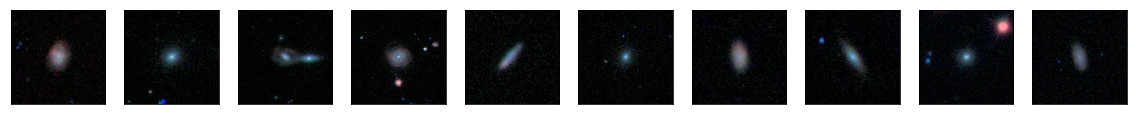

In [48]:
n = 10
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test[i].reshape(424, 424, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()
plt.savefig('actual.png')

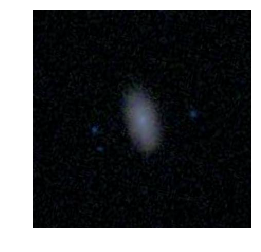

In [35]:
for i in range(1,11):
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.savefig('actual'+str(i)+'.png')

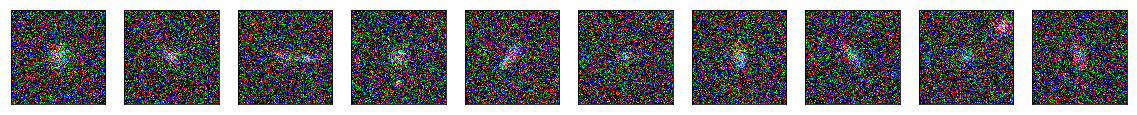

In [37]:
# plot noised data
n = 10
plt.figure(figsize=(20,4))
for i in range(1,n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(424, 424, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()
plt.savefig('noisy.png')

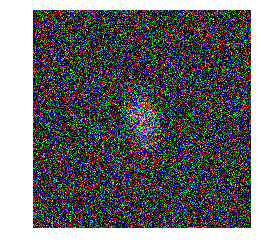

In [34]:
for i in range(1,11):
    plt.imshow(x_test_noisy[i])
    plt.axis('off')
    plt.savefig('noisy'+str(i)+'.png')

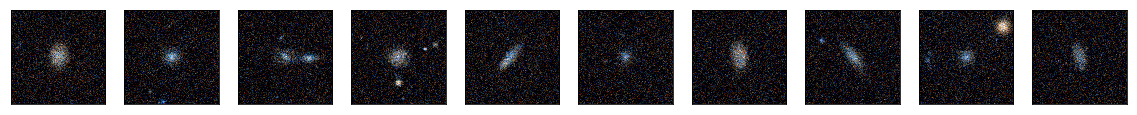

In [41]:
# apply a median filter as a baseline
plt.figure(figsize=(20,4))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    median_denoise_image = ndimage.median_filter(x_test_noisy[i], 3)
    plt.imshow(median_denoise_image.reshape(424, 424, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()
plt.savefig('median.png')

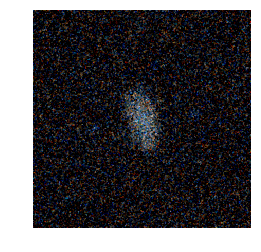

In [33]:
for i in range(1,11):
    median_denoise_image = ndimage.median_filter(x_test_noisy[i], 3)
    plt.imshow(median_denoise_image)
    plt.axis('off')
    plt.savefig('median'+str(i)+'.png')

In [42]:
# build a denoising autoencoder

input_img = Input(shape=(424,424,3))

x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 424, 424, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 424, 424, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 212, 212, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 212, 212, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 106, 106, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 32)      9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 212, 212, 32)      0         
__________

In [9]:
import pydot
import graphviz
from keras.utils import plot_model

plot_model(autoencoder, to_file='denoising_ae_model.png', show_shapes=True)

In [8]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=16,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 647 samples, validate on 932 samples
Epoch 1/100
647/647 [==============================] - 27s 41ms/step - loss: 0.2200 - val_loss: 0.1867
Epoch 2/100
647/647 [==============================] - 24s 38ms/step - loss: 0.1641 - val_loss: 0.1665
Epoch 3/100
647/647 [==============================] - 23s 35ms/step - loss: 0.1498 - val_loss: 0.1368
Epoch 4/100
647/647 [==============================] - 23s 36ms/step - loss: 0.1460 - val_loss: 0.1494
Epoch 5/100
647/647 [==============================] - 24s 38ms/step - loss: 0.1436 - val_loss: 0.1344
Epoch 6/100
647/647 [==============================] - 23s 35ms/step - loss: 0.1428 - val_loss: 0.1741
Epoch 7/100
647/647 [==============================] - 23s 36ms/step - loss: 0.1419 - val_loss: 0.1390
Epoch 8/100
647/647 [==============================] - 24s 38ms/step - loss: 0.1414 - val_loss: 0.1372
Epoch 9/100
647/647 [==============================] - 23s 35ms/step - loss: 0.1429 - val_loss: 0.1366
Epoch 10/100
647/647 [=====

In [9]:
# save our model to load easier later
autoencoder.save('denoising_autoencoder.h5')

In [44]:
# load the model if needed
autoencoder = load_model('denoising_autoencoder.h5')

In [46]:
# Predict the Autoencoder output from corrupted test images
cleaned_x = autoencoder.predict(x_test_noisy)

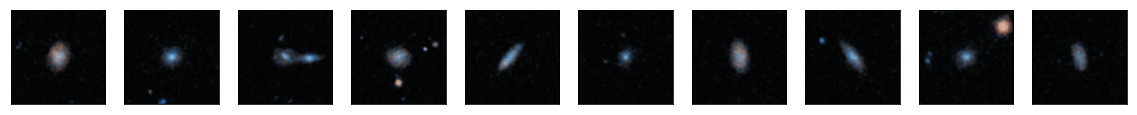

In [47]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n+1):
    ax = plt.subplot(1, n, i)
    plt.imshow(cleaned_x[i].reshape(424,424,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
#plt.show()
plt.savefig('denoised.png')

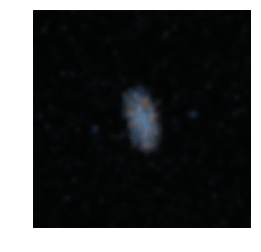

In [32]:
for i in range(1,11):
    plt.imshow(cleaned_x[i])
    plt.axis('off')
    plt.savefig('denoised'+str(i)+'.png')